In [1]:
#импортируем разное
import matplotlib.pyplot as plt
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, Dropout, UpSampling2D, MaxPooling2D, Input, Add, Activation
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
#загрузим датасет
batch_size = 8
image_size = 128

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/users/user/8k',
    label_mode= None,
    batch_size=batch_size,
    image_size=(image_size, image_size),
    shuffle=True,
    interpolation = 'area',
    seed=123
)                  

#препроцессинг
@tf.function
def process(x):
    #приводим значения пикселей к [0...1]
    return (x/256.0)

dataset = dataset.map(process)
dataset = dataset.shuffle(50).cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(50)

Found 8091 files belonging to 1 classes.


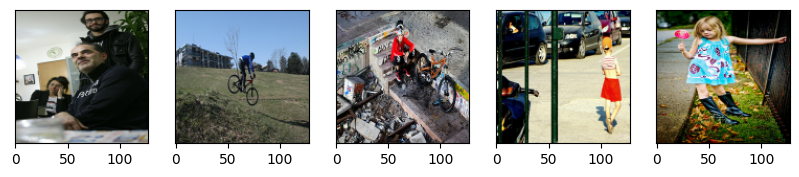

In [18]:
#посмотрим на картинки
def imshow(): 
    n = 5
    plt.figure(figsize=(10, 6))
    #берем один батч из датасета. проходимся по первым n
    for images in dataset.take(1):
        for i in range(n):
            img = images[i]
            ax = plt.subplot(3, n, i + 1 + n)
            
            plt.imshow(img, cmap='gist_gray')
         #   plt.axis('off')
            ax.get_yaxis().set_visible(False)           
    plt.show()
imshow()

In [4]:
#мат. часть процесса квантования.
#Подробнее: https://keras.io/examples/generative/vq_vae/

class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # Параметр "beta" обычно в пределах [0.25 ... 2].
        # чем больше значение beta, тем сильнее "изменяется" сам энкодер
        # чм меньше, тем сильнее подстраивается codebook
        
        self.beta = beta

        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Квантование
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        quantized = tf.reshape(quantized, input_shape)
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices
    #нужно для сохранения в h5
    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.num_embeddings,
            "arg2": self.embedding_dim,
            "arg3": self.beta,
        })
        return config

In [5]:
#Создадим слой квантования
#num_embeddings - количесство индексов (эмбеддингов) в кодовой книге
#embedding_dim - количество параметров в каждом из эмбеддингов
#Устанавливаем равным количеству фильтров в последнем слое энкодера

vq_layer = VectorQuantizer(num_embeddings = 512, embedding_dim = 4, name="vector_quantizer")

In [6]:
#Нейросети

latent_size = int(image_size / 2**2)
#т.к. 2 "уровня" спуска и подьема

def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1, activation=keras.activations.swish)(x)
        x = layers.Conv2D(width/2, kernel_size=1, activation=keras.activations.swish)(x)
        x = layers.Conv2D(width/2, kernel_size=3, padding="same", activation=keras.activations.swish)(x)
        x = layers.Conv2D(width, kernel_size=1, activation=keras.activations.swish)(x)
        x = layers.Add()([x, residual])
        return x
    return apply

#для наглядности распишу без циклов
def get_encoder(image_size):
    image = keras.Input(shape=(image_size, image_size, 3))
    
    x = image
    
    x = ResidualBlock(64)(x)
    x = ResidualBlock(64)(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    
    x = ResidualBlock(128)(x)
    x = ResidualBlock(128)(x)
    x = ResidualBlock(128)(x)
    x = ResidualBlock(128)(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    
    #добавляем слой сильно уменьшающий кол-во фильтров (обычно до 4)
    x = layers.Conv2D(4, kernel_size=1, activation=keras.activations.swish)(x)
    
    #добавляем слой квантования
    x = vq_layer(x)    

    return keras.Model(image, x, name="encoder")

def get_decoder(latent_size):
    latent = keras.Input(shape=(latent_size, latent_size, 4))
    
    x = latent
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
    
    x = ResidualBlock(128)(x)
    x = ResidualBlock(128)(x)
    x = ResidualBlock(128)(x)
    x = ResidualBlock(128)(x)
    x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
    
    x = ResidualBlock(64)(x)
    x = ResidualBlock(64)(x)
    x = ResidualBlock(64)(x)
    x = ResidualBlock(64)(x)
    
    #обратно в картинку (3 фильтра, 0...1 - sigmoid)
    x = layers.Conv2D(3, kernel_size=1, activation="sigmoid")(x)    
    
    return keras.Model(latent, x, name="decoder")

def get_discriminator(image_size, discriminator_widths):
    image = keras.Input(shape=(image_size, image_size, 3))
    
    x = image
    
    for width in discriminator_widths:
        x = ResidualBlock(width)(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        x = ResidualBlock(width)(x)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    return keras.Model(image, x, name="discriminator")

In [7]:
class Model(keras.Model):
    def __init__(self, image_size, latent_size):
        super().__init__()
        
        self.encoder = get_encoder(image_size)
        self.decoder = get_decoder(latent_size)
        self.discriminator = get_discriminator(image_size, [32, 64, 96, 128, 256])
        
        #ema штуки
        
        self.ema_encoder = get_encoder(image_size)
        self.ema_decoder =  get_decoder(latent_size)
        
        self.ema_encoder.set_weights(self.encoder.get_weights())
        self.ema_decoder.set_weights(self.decoder.get_weights())
        
        self.ema = 0.999
        
        self.lr = 1e-3
        self.enc_optimizer = tf.keras.optimizers.Adam(self.lr, clipnorm=1.0)
        self.dec_optimizer = tf.keras.optimizers.Adam(self.lr, clipnorm=1.0)
        self.disc_optimizer = tf.keras.optimizers.Adam(self.lr, clipnorm=1.0)
        
    def gan_loss(self,logits, is_real):
        if is_real:
            labels = tf.ones_like(logits)
        else:
            labels = tf.zeros_like(logits)
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels, logits)
        return loss
        
    @tf.function
    def train_step(self, x):
        with tf.GradientTape() as tape_e, tf.GradientTape() as tape_d, tf.GradientTape() as tape_disc:
           
            latent = self.encoder(x, training=True)
            
            reconstructions = self.decoder(latent, training=True)

            #Добавляем loss кодовой книги, чтобы все ее значения также обучались и подстраивались
            reconstruction_loss = tf.reduce_mean((x - reconstructions) ** 2, axis = (1,2,3)) + sum(self.encoder.losses)
            
            gan_mode = True
            
            if gan_mode:
                fake_result = self.discriminator(reconstructions, training=True)
                real_results = self.discriminator(x, training=True)
            
                gen_fake_loss = self.gan_loss(fake_result, True)
                
                disc_fake_loss = self.gan_loss(fake_result, False)
                disc_real_loss = self.gan_loss(real_results, True)
            
                total_loss = reconstruction_loss + gen_fake_loss/100
            
                disc_loss = disc_real_loss + disc_fake_loss
        
            else:
                total_loss = reconstruction_loss
            

        grads_e = tape_e.gradient(total_loss, self.encoder.trainable_variables)
        self.enc_optimizer.apply_gradients(zip(grads_e, self.encoder.trainable_variables))
        
        grads_d = tape_d.gradient(total_loss, self.decoder.trainable_variables)
        self.dec_optimizer.apply_gradients(zip(grads_d, self.decoder.trainable_variables))
        
        #обновление ema весов
        
        for weight, ema_weight in zip(self.encoder.weights, self.ema_encoder.weights):
            ema_weight.assign(self.ema * ema_weight + (1 - self.ema) * weight)
            
        for weight, ema_weight in zip(self.decoder.weights, self.ema_decoder.weights):
            ema_weight.assign(self.ema * ema_weight + (1 - self.ema) * weight)
        
        if gan_mode:
            grads_disc = tape_disc.gradient(disc_loss, self.discriminator.trainable_variables)
            self.disc_optimizer.apply_gradients(zip(grads_disc, self.discriminator.trainable_variables))
        
        return total_loss
    
    def testing(self, n):
        plt.figure(figsize=(10, 10))
        for images in dataset.take(1):
            latent = self.encoder(images)
            recon = self.decoder(latent)
            disc_on_real = self.discriminator(images)
            disc_on_fake = self.discriminator(recon)
            for i in range(min(n, len(images))):
                ax = plt.subplot(3, n, i + 1)
                plt.imshow(images[i])
                plt.title(disc_on_real[i].numpy()[0])
                plt.axis("off")

                ax = plt.subplot(3, n, i + 1 + n)
                plt.imshow(np.clip(latent[i].numpy()[:, :, 0:3], 0, 1))
                plt.axis("off")

                ax = plt.subplot(3, n, i + 1 + n*2)
                plt.imshow(np.clip(recon[i].numpy(), 0, 1))
                plt.title(disc_on_fake[i].numpy()[0])
                plt.axis("off")
                
        plt.show()
        
    def ema_testing(self, n):
        plt.figure(figsize=(10, 10))
        for images in dataset.take(1):
            latent = self.ema_encoder(images)
            recon = self.ema_decoder(latent)
            disc_on_real = self.discriminator(images)
            disc_on_fake = self.discriminator(recon)
            for i in range(min(n, len(images))):
                ax = plt.subplot(2, n, i + 1)
                plt.imshow(images[i])
                plt.title(disc_on_real[i].numpy()[0])
                plt.axis("off")


                ax = plt.subplot(2, n, i + 1 + n)
                plt.imshow(np.clip(recon[i].numpy(), 0, 1))
                plt.title(disc_on_fake[i].numpy()[0])
                plt.axis("off")

        plt.show()

model = Model(image_size, latent_size)

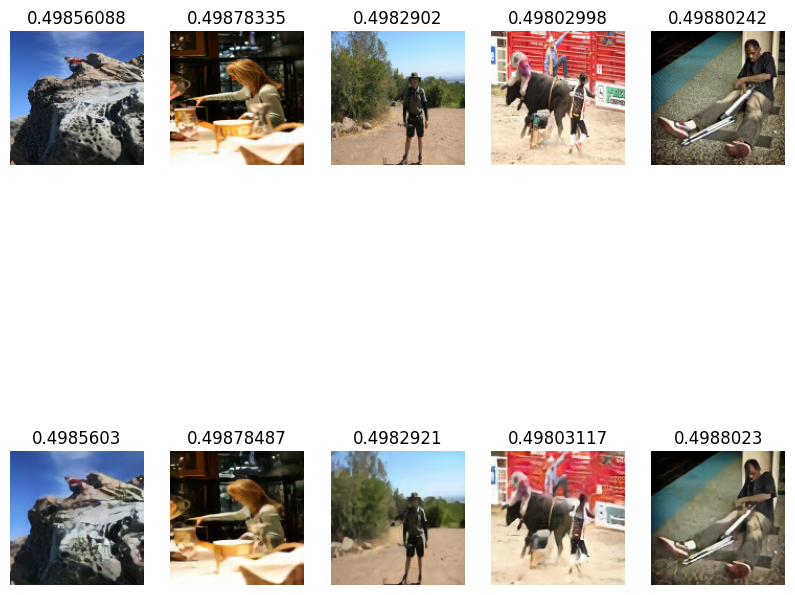

In [19]:
model.ema_testing(5)

эпоха 15
ошибка: 0.013304540887475014


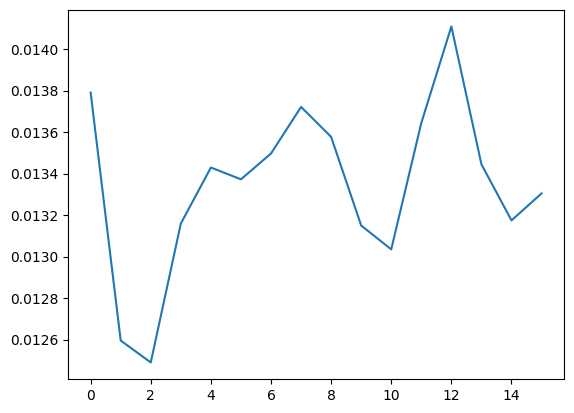

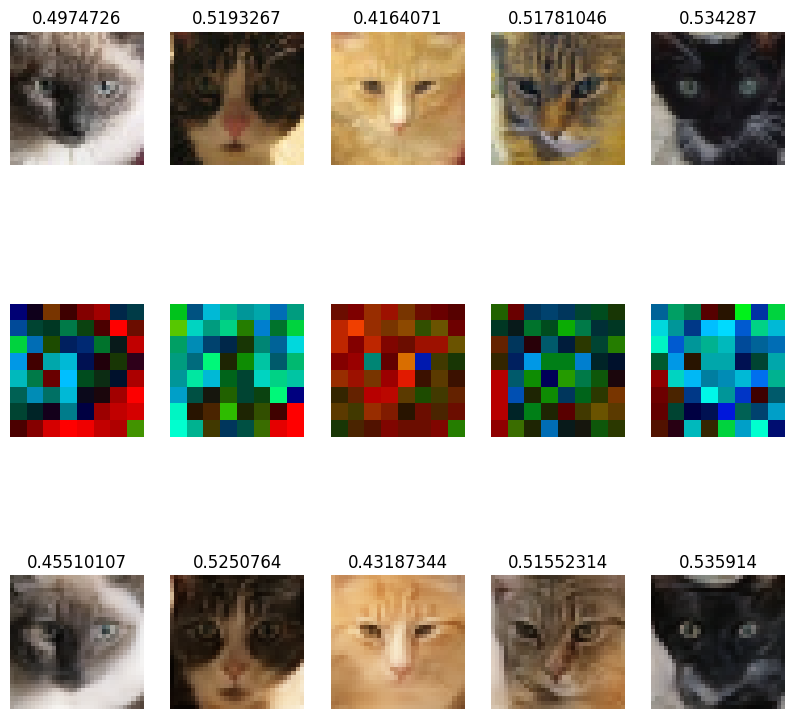

KeyboardInterrupt: 

In [16]:
#обучаем
epochs = 50
hist = np.array(np.empty([0]))
from IPython.display import clear_output
for epoch in range(epochs):
    midloss = 0
    for step, x in enumerate(dataset):
        if tf.shape(x)[0] == batch_size: #проверяем целостность батча
            midloss += tf.reduce_mean(model.train_step(x), axis = 0)

        if(step == 10):  
            clear_output(wait=True)
            print('эпоха ' + str(epoch))
            print('ошибка: ' + str(float(midloss/10)))
            hist = np.append(hist, float(midloss/10))
            plt.plot(np.arange(0,len(hist)), hist)
            plt.show()
            model.testing(5)

In [21]:
#сохранить
#аналогично

In [9]:
#загрузить
model.ema_encoder.load_weights("big_vqgan_encoder.h5")
model.ema_decoder.load_weights("big_vqgan_decoder.h5")
model.encoder.load_weights("big_vqgan_encoder.h5")
model.decoder.load_weights("big_vqgan_decoder.h5")

In [20]:
#Расчитаем FID метрику
#подробнее: https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

def calculate_fid(model, images1, images2):
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

In [21]:
cc = 0
for images in dataset.take(10):
    
    latent = model.ema_encoder(images)
    recon = model.ema_decoder(latent)
    images1 = tf.cast(images, tf.float32)*255
    images2 = tf.cast(recon, tf.float32)*255
    images1 = preprocess_input(images1)
    images2 = preprocess_input(images2)
    images1 = tf.image.resize(images1, (299,299))
    images2 = tf.image.resize(images2, (299,299))
    
    if cc == 0:
        images1_array = images1
        images2_array = images2
    else:
        images1_array = tf.concat([images1, images1_array], axis = 0)
        images2_array = tf.concat([images2, images2_array], axis = 0)
    cc+=1
fid = calculate_fid(inception_model, images1_array, images2_array)
print("FID : ", fid)

FID :  172.8171357780834


In [13]:
model.decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 4)]  0           []                               
                                                                                                  
 conv2d_41 (Conv2D)             (None, 32, 32, 128)  640         ['input_2[0][0]']                
                                                                                                  
 conv2d_42 (Conv2D)             (None, 32, 32, 128)  147584      ['conv2d_41[0][0]']              
                                                                                                  
 conv2d_43 (Conv2D)             (None, 32, 32, 256)  33024       ['conv2d_42[0][0]']              
                                                                                            

 conv2d_66 (Conv2D)             (None, 64, 64, 64)   8256        ['add_19[0][0]']                 
                                                                                                  
 conv2d_67 (Conv2D)             (None, 64, 64, 64)   36928       ['conv2d_66[0][0]']              
                                                                                                  
 conv2d_68 (Conv2D)             (None, 64, 64, 128)  8320        ['conv2d_67[0][0]']              
                                                                                                  
 add_20 (Add)                   (None, 64, 64, 128)  0           ['conv2d_68[0][0]',              
                                                                  'add_19[0][0]']                 
                                                                                                  
 conv2d_69 (Conv2D)             (None, 64, 64, 64)   8256        ['add_20[0][0]']                 
          